# Implementing the Q2R Ising model

In [147]:
import numpy as np
import matplotlib.pyplot as plt
    
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, m):
        self.m = m

        self.array = np.zeros(m, dtype=np.int)-1

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[self.m//2] = 1
        self.image = [self.array.copy()]

    def start_random(self):
        """Start with random values in the top row."""
        self.array = np.random.choice([-1,1],self.m)
        self.image = [self.array.copy()]

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        # TODO: Check string length
        self.array[0] = np.array([int(x) for x in s])-1
        self.image = [self.array.copy()]
        
    def step(self):
        self._step()
        self.image.append(self.array.copy())
    
    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def draw(self):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = (np.array(self.image))
        plt.figure(figsize=(20,20))
        plt.imshow(a, cmap='Blues', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

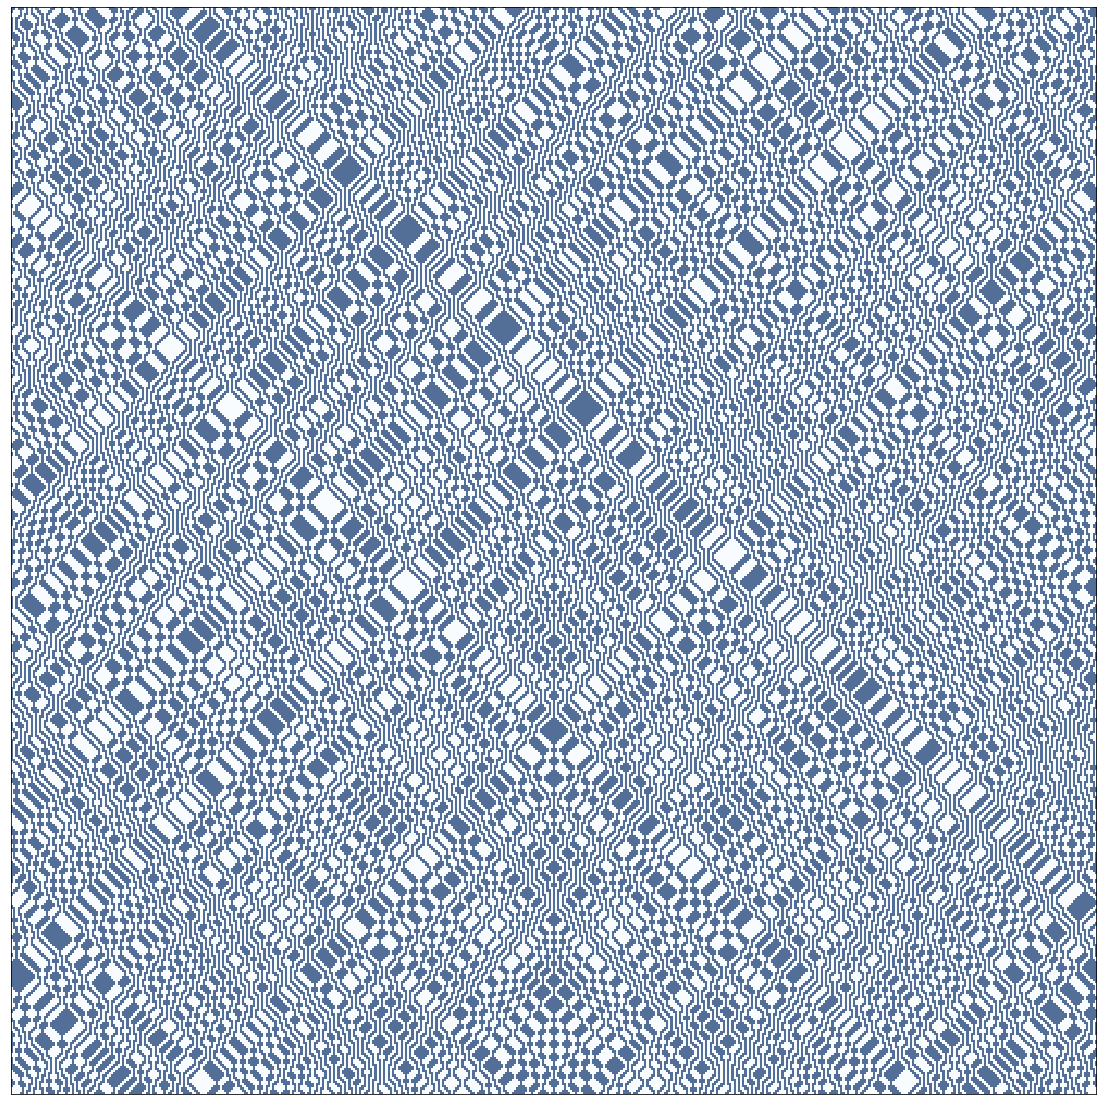

In [157]:
from scipy.ndimage.filters import correlate1d

class Ising(Cell1D):
    def __init__(self, m):
        Cell1D.__init__(self, m)
        
        self.ker = np.array([-1,0,-1])
        c0 = np.array([True,False]*(m//2+1))
        c0 = c0[0:m]
        c1 = ~c0
        self.c = (c0,c1)
        self.i = 0
    def _step(self):
        H = correlate1d(self.array, self.ker, mode='wrap')
        H = H*self.array
        c = self.c[self.i]
        self.i += 1
        self.i %= 2
        sites = (H==0) & c
        self.array[sites] *= -1

ising = Ising(499)
ising.start_random()
ising.loop(499)
ising.draw()